In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import os
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
import matplotlib.ticker as mticker
from collections import defaultdict
# Import define_model from model.py.
from model import define_model
from model import Transformer

In [10]:
import torch
from model import define_model  # or from wherever you defined the model

# 1. Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Rebuild the model architecture
model = define_model(device=device, use_checkpoint=True)

# 3. Load the saved weights
model.load_state_dict(torch.load("model_final.pth", map_location=device))

# 4. Set model to evaluation mode
model.eval()


Transformer(
  (x_pre): PreLayer(
    (linear): Linear(in_features=3, out_features=256, bias=True)
  )
  (y_pre): PreLayer(
    (linear): Linear(in_features=1, out_features=256, bias=True)
  )
  (pos): PositionalEncoding()
  (enc): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attn): SelfAttention(
          (query): Linear(in_features=256, out_features=256, bias=True)
          (key): Linear(in_features=256, out_features=256, bias=True)
          (value): Linear(in_features=256, out_features=256, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (ff): FeedForward(
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (relu): ReLU()
          (linear2): Linear(in_features=512, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        

In [11]:
from main import load_and_preprocess_data, create_sequences, create_dataloaders

directory_path = 'prepared_data.parquet'
lookback = 24
horizon = 24
num_epochs = 30
batch_size = 64
model_save_path = 'model_final.pth'

final_data, daily_data, final_data_context, scaler, target_feature = load_and_preprocess_data(directory_path)
encoder_inputs, decoder_inputs, decoder_targets = create_sequences(
        final_data, daily_data, final_data_context, lookback, horizon, target_feature)
train_dataloader, val_dataloader, test_dataloader, test_encoder_inputs, test_targets_tensor = create_dataloaders(
        encoder_inputs, decoder_inputs, decoder_targets, batch_size)

In [12]:
import matplotlib.pyplot as plt

def plot_iterative(true_vals, pred_vals, label="Model"):
    plt.figure(figsize=(30, 7))
    plt.plot(true_vals, label="True Values", color="blue", linewidth=0.5)
    plt.plot(pred_vals, label=f"Predicted by {label}", color="red", linewidth=0.5)
    plt.title(f"Iterative Forecast: {label}")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
import numpy as np
from main import make_predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

device = model.device
predictions_per_day = [[] for _ in range(horizon)]
true_values_per_day = [[] for _ in range(horizon)]

for test_index in range(len(test_encoder_inputs)):
    input_sequence = test_encoder_inputs[test_index]
    true_values = test_targets_tensor[test_index].cpu().numpy().reshape(-1)
    predicted_values = make_predictions(model, input_sequence, true_values, horizon, device)

    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1)).flatten()
    true_values = scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()

    for i in range(horizon):
        predictions_per_day[i].append(predicted_values[i])
        true_values_per_day[i].append(true_values[i])

all_preds = np.array(predictions_per_day).flatten()
all_true = np.array(true_values_per_day).flatten()

mse = mean_squared_error(all_true, all_preds)
mae = mean_absolute_error(all_true, all_preds)
mape = mean_absolute_percentage_error(all_true, all_preds)

print(f"📊 Evaluation Metrics for JIT:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {mse:.4f}")
print(f"MAPE: {mape:.2f}%")



📊 Evaluation Metrics for JIT:
MAE:  4.1892
RMSE: 28.6436
MAPE: 0.03%


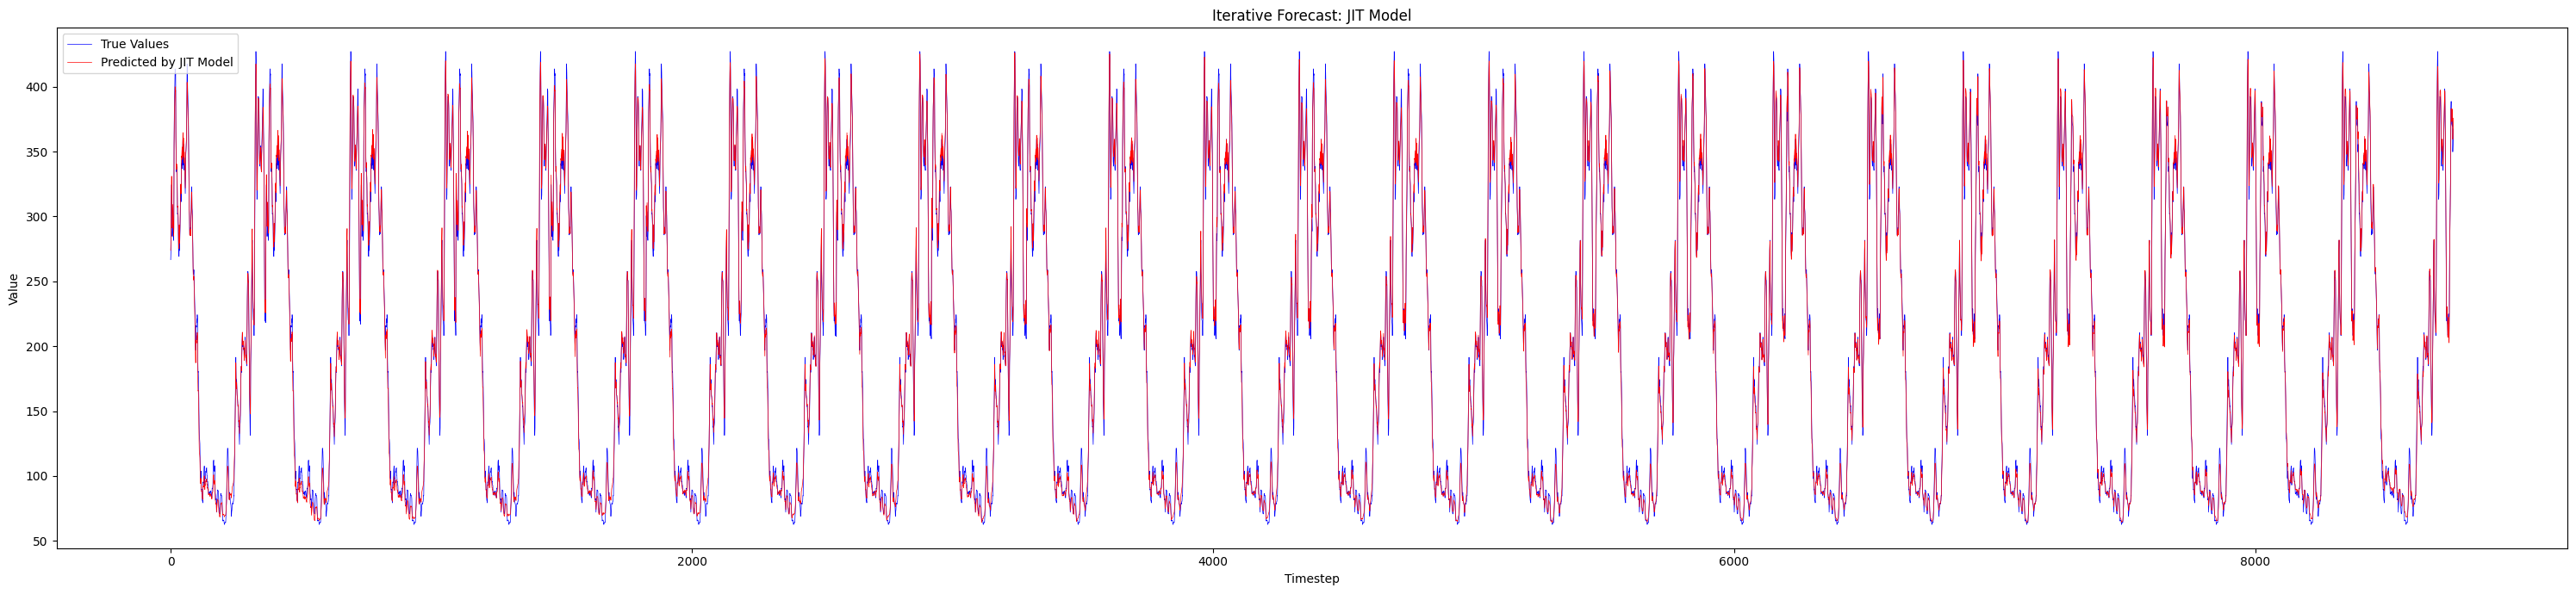

In [14]:
plot_iterative(all_true, all_preds, label="JIT Model")

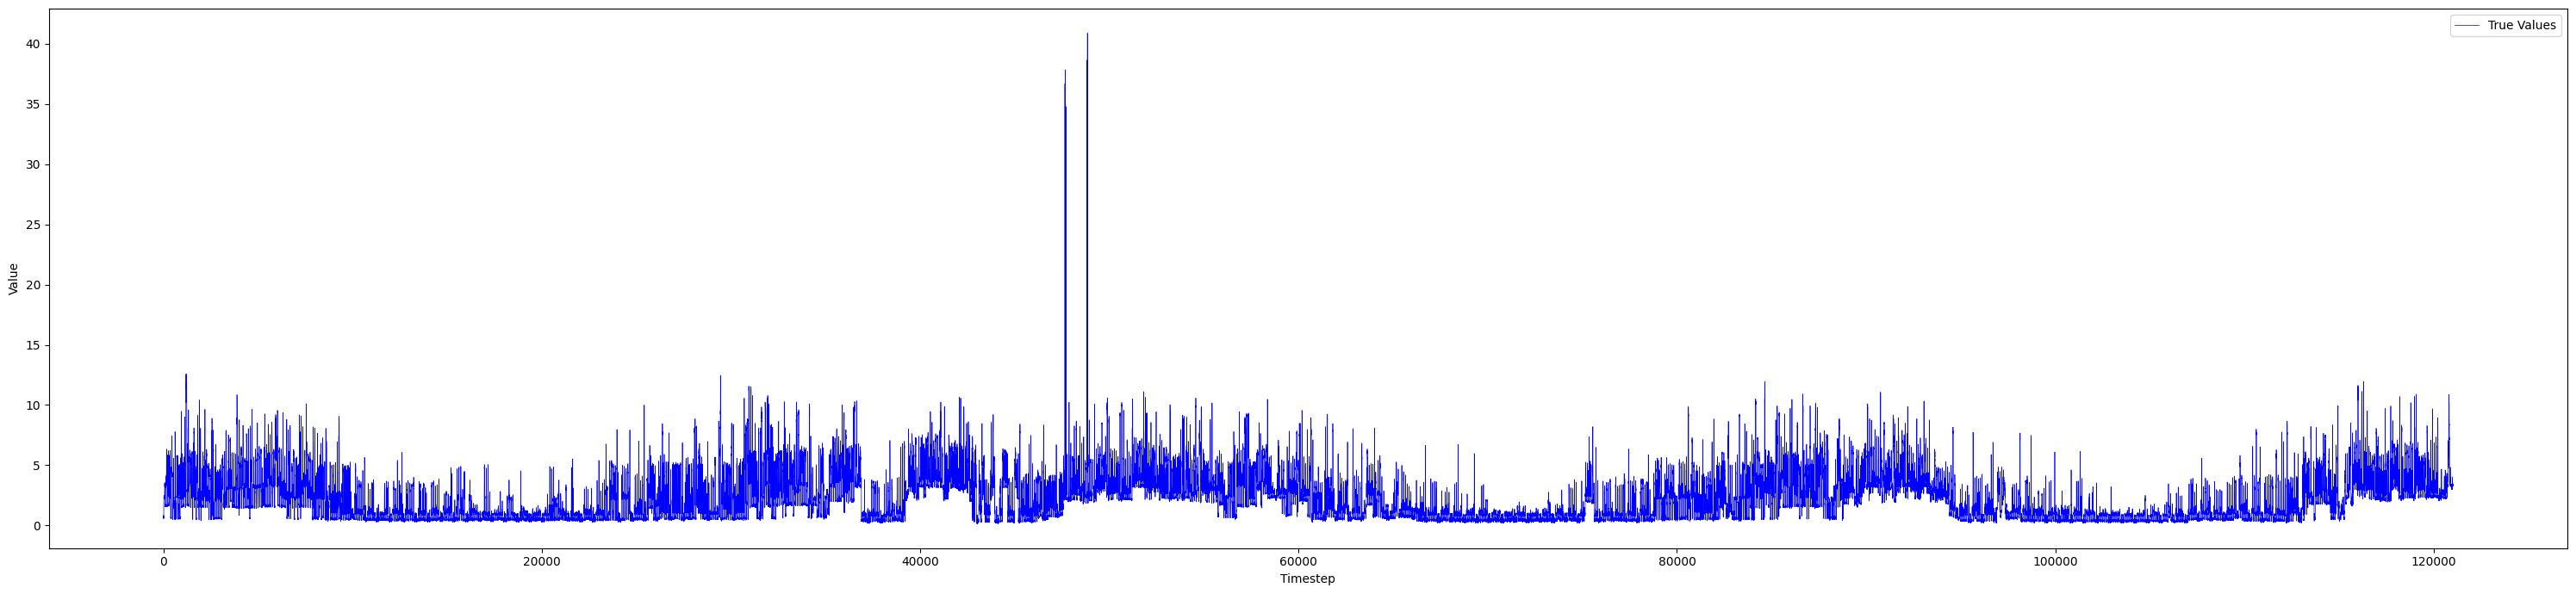

In [23]:
import pandas as pd

df = pd.read_csv('mm79158.csv', sep=';')
df['vrednost'] = df['vrednost'].str.replace(',', '.').astype(float)
values = df['vrednost'].values
test = len(values) * 0.3
#values = values[:int(test)]

plt.figure(figsize=(30, 7))
plt.plot(values, label="True Values", color="blue", linewidth=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

def horizon_rolling_forecast(model, initial_encoder_input, X_test, forecast_horizon, input_window, scaler, decoder_context=7, device='cpu'):
    preds = []
    current_encoder_input = initial_encoder_input.copy()  # shape: (input_window, feature_dim)

    model.eval()
    total_chunks = len(X_test) // forecast_horizon

    for i in range(total_chunks):
        print(f"🔮 Forecast chunk {i + 1}/{total_chunks}", end='\r', flush=True)

        # Convert encoder input to tensor
        enc_tensor = torch.tensor(current_encoder_input).float().unsqueeze(0).to(device)  # shape: (1, input_window, feature_dim)

        # Prepare decoder input (use true values if available, otherwise zeros or predictions)
        decoder_input = torch.zeros(1, forecast_horizon, 1).to(device)  # shape: (1, horizon, 1)

        # Run prediction
        with torch.no_grad():
            output = model(enc_tensor, decoder_input)  # shape: (1, horizon)
            prediction = output.squeeze(0).cpu().numpy()  # shape: (horizon,)

        preds.extend(prediction.tolist())

        # Prepare next encoder input
        x_next_chunk = X_test[i * forecast_horizon: (i + 1) * forecast_horizon]  # shape: (horizon, feature_dim)
        x_next_features = x_next_chunk[:, 1:]  # exclude target column

        combined = np.concatenate([
            prediction.reshape(-1, 1),  # predicted targets
            x_next_features
        ], axis=1)  # shape: (horizon, feature_dim)

        current_encoder_input = np.concatenate([
            current_encoder_input,
            combined
        ], axis=0)[-input_window:]  # Keep last `input_window` steps

    preds = np.array(preds).reshape(-1, 1)
    return scaler.inverse_transform(preds).flatten()


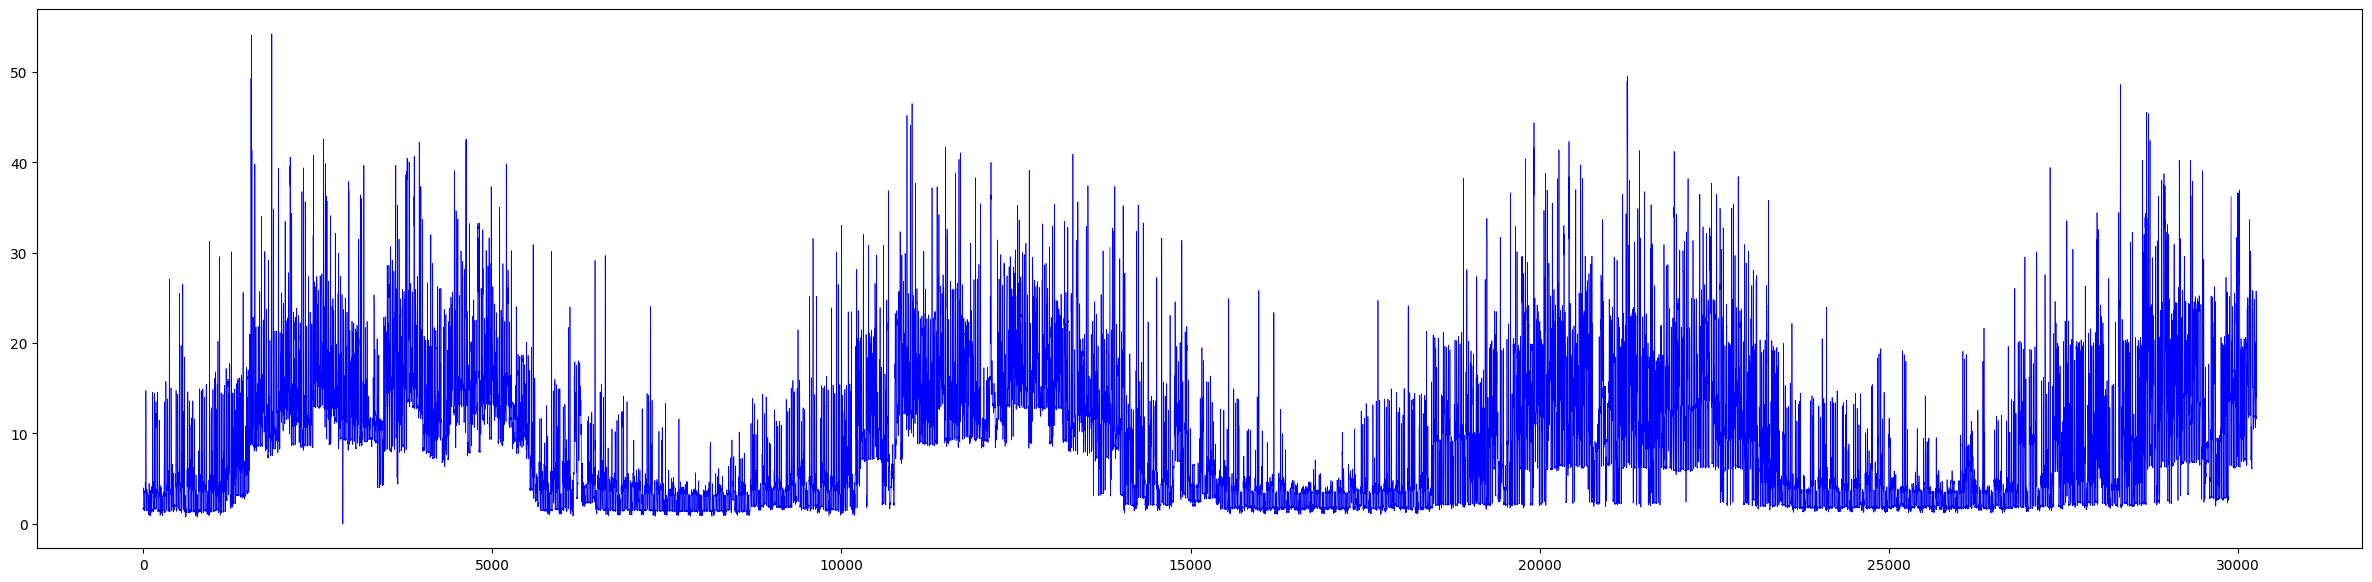

In [ ]:
import pandas as pd

data = pd.read_csv("mm79158.csv", sep=";", decimal=",", parse_dates=["ts"])
data = data.set_index("ts")
data = data.rename(columns={'vrednost': 'cntr'})

data.rename_axis('Date_Time', inplace=True)
daily_data = data.resample('h').sum().reset_index()
daily_data['cntr'] = daily_data['cntr'].round(2)


#Simple moving average and outlier handling.
window_size = 7
daily_data['SMA_7'] = daily_data['cntr'].rolling(window=window_size).mean()
daily_data['SMA_7'] = daily_data['SMA_7'].bfill()
Q1 = daily_data['cntr'].quantile(0.25)
Q3 = daily_data['cntr'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = daily_data[(daily_data['cntr'] < (Q1 - 1.5 * IQR)) | (daily_data['cntr'] > (Q3 + 1.5 * IQR))]
average_max = daily_data['cntr'].nlargest(window_size).mean()
daily_data.loc[outliers_iqr.index, 'cntr'] = average_max

# Add contextual features and scale data.
daily_data['day_of_week'] = daily_data['Date_Time'].dt.dayofweek
daily_data['month'] = daily_data['Date_Time'].dt.month
daily_data['year'] = daily_data['Date_Time'].dt.year
scaler = RobustScaler()
daily_data['SMA_7'] = scaler.fit_transform(daily_data[['SMA_7']])
joblib.dump(scaler, 'scaler.pkl')# Save scaler for future use.
day_of_week_scaler = StandardScaler()
daily_data['day_of_week'] = day_of_week_scaler.fit_transform(daily_data[['day_of_week']])

# Selecting features for the model.
features = ['SMA_7', 'day_of_week']
target_feature = 'SMA_7'
context_features = ['SMA_7', 'day_of_week', 'month']

# Scale context data.
context_scaler = StandardScaler()
context_data = context_scaler.fit_transform(daily_data[context_features])

# Reduce context dimensionality using PCA.
pca = PCA(n_components=1)
context_data_reduced = pca.fit_transform(context_data)

# Prepare final data.
final_data = daily_data[features]
final_data_context = context_data_reduced



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_encoder_decoder_sequences(input_data, target_data, context_data, encoder_seq_length, decoder_seq_length):
    """
    Generates encoder-decoder sequences for the model.
    """
    encoder_inputs, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(input_data) - encoder_seq_length - decoder_seq_length):
        encoder_input = input_data[i: i + encoder_seq_length].values
        context_input = np.tile(context_data[i: i + encoder_seq_length], (1, 1))
        encoder_input = np.concatenate([encoder_input, context_input], axis=1)

        # No .values since target_data is already a NumPy array
        decoder_input = target_data[i + encoder_seq_length - 1: i + encoder_seq_length + decoder_seq_length - 1].reshape(-1, 1)
        decoder_target = target_data[i + encoder_seq_length: i + encoder_seq_length + decoder_seq_length].reshape(-1, 1)

        encoder_inputs.append(encoder_input)
        decoder_inputs.append(decoder_input)
        decoder_targets.append(decoder_target)

    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(decoder_targets)


def feature_engineering(csv_path, window_size=7):
    df = pd.read_csv(csv_path, sep=";", decimal=",", parse_dates=["ts"])
    df = df.set_index("ts").rename(columns={'vrednost': 'cntr'})
    df.rename_axis('Date_Time', inplace=True)
    df = df.resample('h').sum().reset_index()
    df['cntr'] = df['cntr'].round(2)

    window_size = 7
    df['SMA_7'] = df['cntr'].rolling(window=window_size).mean().bfill()
    Q1, Q3 = df['cntr'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = (df['cntr'] < (Q1 - 1.5 * IQR)) | (df['cntr'] > (Q3 + 1.5 * IQR))
    average_max = df['cntr'].nlargest(window_size).mean()
    df.loc[outliers, 'cntr'] = average_max

    df['day_of_week'] = df['Date_Time'].dt.dayofweek
    df['month'] = df['Date_Time'].dt.month
    df['year'] = df['Date_Time'].dt.year
    return df


def scaling_and_pca(df, test_size=0.3, val_size=0.1):
    features = df[['SMA_7', 'day_of_week']].copy()
    target = df[['SMA_7']].copy()
    context = df[['SMA_7', 'day_of_week', 'month']].copy()

    indices = np.arange(len(df))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, shuffle=False)
    val_relative_size = val_size / (1 - test_size)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_relative_size, shuffle=False)

    scaler_target = RobustScaler().fit(target.iloc[train_idx])
    scaler_day = StandardScaler().fit(df[['day_of_week']].iloc[train_idx])
    context_scaler = StandardScaler().fit(context.iloc[train_idx])
    pca = PCA(n_components=1).fit(context_scaler.transform(context.iloc[train_idx]))

    features.loc[train_idx, 'SMA_7'] = scaler_target.transform(target.iloc[train_idx])
    features.loc[val_idx, 'SMA_7'] = scaler_target.transform(target.iloc[val_idx])
    features.loc[test_idx, 'SMA_7'] = scaler_target.transform(target.iloc[test_idx])

    features.loc[train_idx, 'day_of_week'] = scaler_day.transform(df[['day_of_week']].iloc[train_idx])
    features.loc[val_idx, 'day_of_week'] = scaler_day.transform(df[['day_of_week']].iloc[val_idx])
    features.loc[test_idx, 'day_of_week'] = scaler_day.transform(df[['day_of_week']].iloc[test_idx])

    reduced_context = np.zeros((len(context), 1))
    reduced_context[train_idx] = pca.transform(context_scaler.transform(context.iloc[train_idx]))
    reduced_context[val_idx] = pca.transform(context_scaler.transform(context.iloc[val_idx]))
    reduced_context[test_idx] = pca.transform(context_scaler.transform(context.iloc[test_idx]))

    joblib.dump(scaler_target, 'scalers/scaler_target.pkl')
    joblib.dump(scaler_day, 'scalers/scaler_day.pkl')
    joblib.dump(context_scaler, 'scalers/scaler_context.pkl')
    joblib.dump(pca, 'scalers/pca.pkl')

    return features, target, reduced_context, train_idx, val_idx, test_idx

def preprocess_and_split_data(csv_path, encoder_seq_length, decoder_seq_length, batch_size=32, test_size=0.3, val_size=0.1):
    df = feature_engineering(csv_path)

    min_len = encoder_seq_length + decoder_seq_length
    df = df.iloc[min_len:].reset_index(drop=True)

    features, target, reduced_context, train_idx, val_idx, test_idx = scaling_and_pca(df, test_size=test_size, val_size=val_size)
    
    enc_inputs, dec_inputs, dec_targets = create_encoder_decoder_sequences(
        features, target.values, reduced_context, encoder_seq_length, decoder_seq_length
    )

    def split_by_index(arr):
        return arr[train_idx], arr[val_idx], arr[test_idx]

    train_enc, val_enc, test_enc = split_by_index(enc_inputs)
    train_dec, val_dec, test_dec = split_by_index(dec_inputs)
    train_tgt, val_tgt, test_tgt = split_by_index(dec_targets)

    def make_loader(enc, dec, tgt):
        dataset = TensorDataset(torch.tensor(enc).float(), torch.tensor(dec).float(), torch.tensor(tgt).float())
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return make_loader(train_enc, train_dec, train_tgt), \
           make_loader(val_enc, val_dec, val_tgt), \
           make_loader(test_enc, test_dec, test_tgt)


def inverse_transform_all(scaler_target, y_scaled):
    return scaler_target.inverse_transform(y_scaled.reshape(-1, 1)).flatten()


In [34]:
import numpy as np
import torch
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, test_loader, device='cpu', scaler_dir='scalers'):
    """
    Evaluates a trained model on the test set with proper inverse transforms and metrics.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader containing test set batches.
        device: 'cpu' or 'cuda'.
        scaler_dir: Directory where scalers are saved.

    Returns:
        y_true, y_pred, metrics_dict
    """
    # Load scalers
    scaler_target = joblib.load(f'{scaler_dir}/scaler_target.pkl')

    # Collect predictions and true targets
    model.eval()
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for enc_input, dec_input, targets in test_loader:
            enc_input = enc_input.to(device)
            dec_input = dec_input.to(device)
            output = model(enc_input, dec_input)
            all_predictions.append(output.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Flatten
    y_pred_scaled = np.concatenate(all_predictions, axis=0).reshape(-1)
    y_true_scaled = np.concatenate(all_targets, axis=0).reshape(-1)

    # Inverse transform
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_target.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

    # Metrics
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) * 100
    }

    return y_true, y_pred, metrics


In [ ]:
train_dataloader, val_dataloader, test_dataloader = preprocess_and_split_data('mm79158.csv', 24, 24, 64)

C:\Users\janav\AppData\Local\Temp\ipykernel_35464\188595921.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.00055258e-01 5.00055258e-01 5.00055258e-01 ... 3.30925004e-04
 3.30925004e-04 3.30925004e-04]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  features.loc[train_idx, 'day_of_week'] = scaler_day.transform(df[['day_of_week']].iloc[train_idx])


IndexError: index 30144 is out of bounds for axis 0 with size 30144